In [1]:
from lec_utils import *


<div class="alert alert-info" markdown="1">

#### Lecture 12


# Text Analysis I
    
</div>


This notebook analyzes the **State of the Union** corpus, 1970-2025. Source: [The American Presidency Project](https://www.presidency.ucsb.edu/documents/presidential-documents-archive-guidebook/annual-messages-congress-the-state-the-union)
- Tasks covered:
  - Cleaning
  - Tokenization with **NLTK**
  - **Part-of-Speech (POS)** tagging with NLTK
  - **Named Entity Recognition (NER)** with spaCy
  - **Sentiment analysis** with VADER

## 1) Environment & Resources

In [1]:
# If you're in a managed environment, you may not need these installs.
# Uncomment if needed.
## ! conda activate qss20
## ! conda install nltk spacy vaderSentiment gensim scikit-learn "scipy<1.13"

import re
import pandas as pd
import nltk

# Download NLTK resources (safe to re-run)
nltk.download('punkt_tab', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
nltk.download('maxent_ne_chunker', quiet=True)  # for NLTK's chunker if needed
nltk.download('words', quiet=True)               # word list for NER chunker
nltk.download('vader_lexicon', quiet=True)       # for SentimentIntensityAnalyzer
nltk.download('stopwords', quiet=True)

import spacy
# You also need to run this following line in the command line
# ! python -m spacy download en_core_web_sm
spacy.load('en_core_web_sm')
import en_core_web_sm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import seaborn as sns
import matplotlib.pyplot as plt

## 2) Load & Quick Peek

In [2]:
with open('../../public_data/stateoftheunion1790-2025.txt') as f:
    text = f.read()
    
print(f"Characters: {len(text):,}")
print("\n--- BEGIN PREVIEW ---")
print(text[:1000])
print("\n--- END PREVIEW ---")

Characters: 10,675,837

--- BEGIN PREVIEW ---
The Project Gutenberg EBook of Complete State of the Union Addresses,
from 1790 to the Present. Speeches beginning in 2002 are from UCSB The American Presidency Project.
Speeches from 2018-2023 were manually downloaded from whitehouse.gov.

Character set encoding: UTF8

The addresses are separated by three asterisks


CONTENTS

  George Washington, State of the Union Address, January 8, 1790
  George Washington, State of the Union Address, December 8, 1790
  George Washington, State of the Union Address, October 25, 1791
  George Washington, State of the Union Address, November 6, 1792
  George Washington, State of the Union Address, December 3, 1793
  George Washington, State of the Union Address, November 19, 1794
  George Washington, State of the Union Address, December 8, 1795
  George Washington, State of the Union Address, December 7, 1796
  John Adams, State of the Union Address, November 22, 1797
  John Adams, State of the Union Add

### Terminology

- In text analysis, each piece of text we want to analyze is called a **document**.<br><small>Here, each speech is a document.</small>

- Documents are made up of **terms**, i.e. words.

- A collection of documents is called a **corpus**.<br><small>Here, the corpus is the set of all SOTU speeches from 1790-2025.</small>

### Extracting speeches

- In the string `sotu`, each document is separated by `'***'`.

In [3]:
speeches_lst = text.split('\n***\n')[1:]
len(speeches_lst)

235

In [4]:
speeches_lst[2]

'\nState of the Union Address\nGeorge Washington\nOctober 25, 1791\n\nFellow-Citizens of the Senate and House of Representatives:\n\n"In vain may we expect peace with the Indians on our frontiers so long as a\nlawless set of unprincipled wretches can violate the rights of hospitality,\nor infringe the most solemn treaties, without receiving the punishment they\nso justly merit."\n\nI meet you upon the present occasion with the feelings which are naturally\ninspired by a strong impression of the prosperous situations of our common\ncountry, and by a persuasion equally strong that the labors of the session\nwhich has just commenced will, under the guidance of a spirit no less\nprudent than patriotic, issue in measures conducive to the stability and\nincrease of national prosperity.\n\nNumerous as are the providential blessings which demand our grateful\nacknowledgments, the abundance with which another year has again rewarded\nthe industry of the husbandman is too important to escape rec

- Note that each "speech" currently contains other information, like the name of the president and the date of the address.

In [5]:
print(speeches_lst[-1][:1000])


Address Before a Joint Session of Congress 
Donald J. Trump
March 4, 2025

The President. Thank you. Thank you very much. Thank you very much. It's a great honor. Thank you very much.

Speaker Johnson, Vice President Vance, the First Lady of the United States, Members of the United States Congress: Thank you very much.

And to my fellow citizens, America is back.

Audience members. U.S.A.! U.S.A.! U.S.A.!

The President. Six weeks ago, I stood beneath the dome of this Capitol and proclaimed the dawn of the golden age of America. From that moment on, it has been nothing but swift and unrelenting action to usher in the greatest and most successful era in the history of our country.

We have accomplished more in 43 days than most administrations accomplished in 4 years or 8 years, and we are just getting started. [Applause] Thank you.

I return to this Chamber tonight to report that America's momentum is back, our spirit is back, our pride is back, our confidence is back, and the America

- Let's extract just the text of each speech and put it in a DataFrame.<br><small>Along the way, we'll use our new knowledge of regular expressions to remove capitalization and punctuation, so we can just focus on the content itself.</small>

In [24]:
def create_speeches_df(speeches_lst):
    def extract_struct(speech):
        L = speech.strip().split('\n', maxsplit=3)
        L[3] = re.sub(r'\n', '', L[3])
        # L[3] = re.sub(r"[^A-Za-z' ]", ' ', L[3]).lower() # Replaces anything OTHER than letters with ' '.
        # L[3] = re.sub(r"it's", 'it is', L[3]).replace(' s ', '')
        return dict(zip(['president', 'date', 'text'], L[1:]))
    speeches = pd.DataFrame(list(map(extract_struct, speeches_lst)))
    # speeches.index = speeches['president'].str.strip() + ': ' + speeches['date']
    # speeches = speeches[['text']]
    return speeches

In [25]:
speeches = create_speeches_df(speeches_lst)
speeches

,president,date,text
0,George Washington,"January 8, 1790",Fellow-Citizens of the Senate and House of Rep...
1,George Washington,"December 8, 1790",Fellow-Citizens of the Senate and House of Rep...
2,George Washington,"October 25, 1791",Fellow-Citizens of the Senate and House of Rep...
...,...,...,...
232,Joseph R. Biden Jr.,"February 7, 2023",Mr. Speaker. Madam Vice President. Our First...
233,Joseph R. Biden Jr.,"March 7, 2024",Good evening. Mr. Speaker. Madam Vice Presiden...
234,Donald J. Trump,"March 4, 2025",The President. Thank you. Thank you very much....


In [26]:
last_sotu_text = speeches.iloc[-1, :]["text"]
last_sotu_text

'The President. Thank you. Thank you very much. Thank you very much. It\'s a great honor. Thank you very much.Speaker Johnson, Vice President Vance, the First Lady of the United States, Members of the United States Congress: Thank you very much.And to my fellow citizens, America is back.Audience members. U.S.A.! U.S.A.! U.S.A.!The President. Six weeks ago, I stood beneath the dome of this Capitol and proclaimed the dawn of the golden age of America. From that moment on, it has been nothing but swift and unrelenting action to usher in the greatest and most successful era in the history of our country.We have accomplished more in 43 days than most administrations accomplished in 4 years or 8 years, and we are just getting started. [Applause] Thank you.I return to this Chamber tonight to report that America\'s momentum is back, our spirit is back, our pride is back, our confidence is back, and the American dream is surging bigger and better than ever before. The American dream is unstoppa

## 3) Cleaning
We'll do light normalization suitable for classic NLP steps.

In [27]:
import re

def basic_clean(s: str) -> str:
    # Normalize newlines and spaces
    s = s.replace("\r\n", "\n").replace("\r", "\n")
    # Remove non-printable chars
    s = ''.join(ch for ch in s if ch.isprintable() or ch in ["\n", "\t"])
    # Normalize spaces around punctuation
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"\s+(\W)", r"\1", s)
    s = re.sub(r"(\W)\s+", r"\1 ", s)
    return s.strip()

clean_text = basic_clean(last_sotu_text)
print(f"Original length: {len(last_sotu_text):,} | Cleaned length: {len(clean_text):,}")
print(clean_text[:1000])

Original length: 59,022 | Cleaned length: 58,946
The President. Thank you. Thank you very much. Thank you very much. It's a great honor. Thank you very much.Speaker Johnson, Vice President Vance, the First Lady of the United States, Members of the United States Congress: Thank you very much.And to my fellow citizens, America is back.Audience members. U.S.A.! U.S.A.! U.S.A.!The President. Six weeks ago, I stood beneath the dome of this Capitol and proclaimed the dawn of the golden age of America. From that moment on, it has been nothing but swift and unrelenting action to usher in the greatest and most successful era in the history of our country.We have accomplished more in 43 days than most administrations accomplished in 4 years or 8 years, and we are just getting started.[Applause] Thank you.I return to this Chamber tonight to report that America's momentum is back, our spirit is back, our pride is back, our confidence is back, and the American dream is surging bigger and better tha

## 4) Tokenization with NLTK

Tokenization is the process of splitting text into individual words or "tokens". We will use NLTK's `word_tokenize` function for this.

In [28]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

sentences = sent_tokenize(last_sotu_text)
words = word_tokenize(last_sotu_text)
words_alpha = [w 
               for w in words 
               if any(ch.isalpha() 
                      for ch in w)]
words_nostop = [w 
                for w in words_alpha 
                if w.lower() not in stop_words]

In [29]:
sentences[0:10]

['The President.',
 'Thank you.',
 'Thank you very much.',
 'Thank you very much.',
 "It's a great honor.",
 'Thank you very much.Speaker Johnson, Vice President Vance, the First Lady of the United States, Members of the United States Congress: Thank you very much.And to my fellow citizens, America is back.Audience members.',
 'U.S.A.!',
 'U.S.A.!',
 'U.S.A.!The President.',
 'Six weeks ago, I stood beneath the dome of this Capitol and proclaimed the dawn of the golden age of America.']

In [30]:
words[0:20]

['The',
 'President',
 '.',
 'Thank',
 'you',
 '.',
 'Thank',
 'you',
 'very',
 'much',
 '.',
 'Thank',
 'you',
 'very',
 'much',
 '.',
 'It',
 "'s",
 'a',
 'great']

In [31]:
words_alpha[0:20]

['The',
 'President',
 'Thank',
 'you',
 'Thank',
 'you',
 'very',
 'much',
 'Thank',
 'you',
 'very',
 'much',
 'It',
 "'s",
 'a',
 'great',
 'honor',
 'Thank',
 'you',
 'very']

In [32]:
words_nostop[0:20]

['President',
 'Thank',
 'Thank',
 'much',
 'Thank',
 'much',
 "'s",
 'great',
 'honor',
 'Thank',
 'much.Speaker',
 'Johnson',
 'Vice',
 'President',
 'Vance',
 'First',
 'Lady',
 'United',
 'States',
 'Members']

## 5) POS Tagging with NLTK

Part-of-speech tagging involves assigning a grammatical category (like noun, verb, adjective, etc.) to each token. We'll use NLTK's `pos_tag` function.

In [33]:
from nltk import pos_tag

last_sotu_sents = sent_tokenize(last_sotu_text)[10:10+5]
pos_tag(word_tokenize(last_sotu_sents[0]))

[('From', 'IN'),
 ('that', 'DT'),
 ('moment', 'NN'),
 ('on', 'IN'),
 (',', ','),
 ('it', 'PRP'),
 ('has', 'VBZ'),
 ('been', 'VBN'),
 ('nothing', 'NN'),
 ('but', 'CC'),
 ('swift', 'NN'),
 ('and', 'CC'),
 ('unrelenting', 'JJ'),
 ('action', 'NN'),
 ('to', 'TO'),
 ('usher', 'VB'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('greatest', 'JJS'),
 ('and', 'CC'),
 ('most', 'RBS'),
 ('successful', 'JJ'),
 ('era', 'NN'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('history', 'NN'),
 ('of', 'IN'),
 ('our', 'PRP$'),
 ('country.We', 'NNS'),
 ('have', 'VBP'),
 ('accomplished', 'VBN'),
 ('more', 'RBR'),
 ('in', 'IN'),
 ('43', 'CD'),
 ('days', 'NNS'),
 ('than', 'IN'),
 ('most', 'JJS'),
 ('administrations', 'NNS'),
 ('accomplished', 'VBN'),
 ('in', 'IN'),
 ('4', 'CD'),
 ('years', 'NNS'),
 ('or', 'CC'),
 ('8', 'CD'),
 ('years', 'NNS'),
 (',', ','),
 ('and', 'CC'),
 ('we', 'PRP'),
 ('are', 'VBP'),
 ('just', 'RB'),
 ('getting', 'VBG'),
 ('started', 'VBN'),
 ('.', '.')]

In [ ]:
from nltk import pos_tag

# POS tag the first N sentences of the last document
N = 5
last_sotu_sents = sent_tokenize(last_sotu_text)[10:10+N]
pos_tagged = [
    pos_tag(word_tokenize(s)) 
    for s in last_sotu_sents]
for i, tagged in enumerate(pos_tagged, 1):
    print(f"\nSentence {i} POS tags:")
    print(tagged)


Sentence 1 POS tags:
[('From', 'IN'), ('that', 'DT'), ('moment', 'NN'), ('on', 'IN'), (',', ','), ('it', 'PRP'), ('has', 'VBZ'), ('been', 'VBN'), ('nothing', 'NN'), ('but', 'CC'), ('swift', 'NN'), ('and', 'CC'), ('unrelenting', 'JJ'), ('action', 'NN'), ('to', 'TO'), ('usher', 'VB'), ('in', 'IN'), ('the', 'DT'), ('greatest', 'JJS'), ('and', 'CC'), ('most', 'RBS'), ('successful', 'JJ'), ('era', 'NN'), ('in', 'IN'), ('the', 'DT'), ('history', 'NN'), ('of', 'IN'), ('our', 'PRP$'), ('country.We', 'NNS'), ('have', 'VBP'), ('accomplished', 'VBN'), ('more', 'RBR'), ('in', 'IN'), ('43', 'CD'), ('days', 'NNS'), ('than', 'IN'), ('most', 'JJS'), ('administrations', 'NNS'), ('accomplished', 'VBN'), ('in', 'IN'), ('4', 'CD'), ('years', 'NNS'), ('or', 'CC'), ('8', 'CD'), ('years', 'NNS'), (',', ','), ('and', 'CC'), ('we', 'PRP'), ('are', 'VBP'), ('just', 'RB'), ('getting', 'VBG'), ('started', 'VBN'), ('.', '.')]

Sentence 2 POS tags:
[('[', 'NN'), ('Applause', 'NNP'), (']', 'NNP'), ('Thank', 'NNP'),

Here's a quick guide to some of the common POS tags:

- NN: Noun, singular or mass
- NNS: Noun, plural
- NNP: Proper noun, singular
- VB: Verb, base form
- VBD: Verb, past tense
- VBG: Verb, gerund or present participle
- JJ: Adjective
- RB: Adverb

## 6) Named Entity Recognition (NER) with spaCy

Named Entity Recognition is the task of identifying and categorizing key information (entities) in text. These entities can be people, places, organizations, dates, and more. We will use the `spaCy` library for this.

Note: For NER, it's often better to use the original, uncleaned text to preserve capitalization, which can be a strong signal for named entities.

Here's a guide to some of the common spaCy NER labels:
- PERSON,"People, including fictional."
- NORP,Nationalities or religious or political groups.
- FAC,"Buildings, airports, highways, bridges, etc."
- ORG,"Companies, agencies, institutions, etc."
- GPE,"Countries, cities, states."
- LOC,"Non-GPE locations, mountain ranges, bodies of water."
- PRODUCT,"Objects, vehicles, foods, etc. (Not services.)"
- EVENT,"Named hurricanes, battles, wars, sports events, etc."
- DATE,Absolute or relative dates or periods.
- TIME,Times smaller than a day.

In [33]:
doc.ents

(Johnson,
 Vance,
 First,
 the United States,
 the United States,
 America,
 U.S.A.!,
 U.S.A.,
 Six weeks ago,
 Capitol,
 America,
 43 days,
 4 years,
 8 years,
 Chamber,
 tonight,
 America,
 American,
 American,
 November 5,
 many decades,
 seven,
 States,
 312,
 Alexander N. Green,
 U.S.A.!,
 U.S.A.,
 Medicaid,
 U.S.A.!,
 U.S.A.,
 2,700,
 525,
 Republican,
 first,
 Americans,
 27,
 1-month,
 the House of Representatives,
 J. Michael Johnson,
 41,
 Johnson,
 Johnson,
 House,
 Green,
 Medicaid,
 Johnson,
 Green,
 Green,
 Medicaid,
 Johnson,
 Congress,
 Chamber,
 Green,
 Congress,
 Na Na,
 Congress,
 Johnson,
 House,
 the past six weeks,
 nearly 100,
 more than 400,
 the first month,
 two,
 George Washington,
 hours,
 U.S.,
 Border Patrol,
 last month,
 Joe Biden,
 American,
 hundreds of thousands,
 fifth,
 Congress,
 Democrats,
 Five,
 five,
 Democrats,
 just this 1 night,
 America,
 America,
 Every day,
 America,
 America,
 Paris,
 World Health Organization,
 anti-American,
 Biden,
 1

In [31]:
nlp = en_core_web_sm.load()

# Process the original text data with spaCy
doc = nlp(last_sotu_text)

# Extract and print the named entities
for ent in doc.ents:
  print(f"Entity: {ent.text}, Label: {ent.label_}")

# Let's just look at the first 1000 characters for a cleaner output
doc_sample = nlp(last_sotu_text[:1000])
for ent in doc_sample.ents:
    print(f"Entity: {ent.text}, Label: {ent.label_}")

Entity: Johnson, Label: PERSON
Entity: Vance, Label: PERSON
Entity: First, Label: ORDINAL
Entity: the United States, Label: GPE
Entity: the United States, Label: ORG
Entity: America, Label: GPE
Entity: U.S.A.!, Label: ORG
Entity: U.S.A., Label: GPE
Entity: Six weeks ago, Label: DATE
Entity: Capitol, Label: FAC
Entity: America, Label: GPE
Entity: 43 days, Label: DATE
Entity: 4 years, Label: DATE
Entity: 8 years, Label: DATE
Entity: Chamber, Label: ORG
Entity: tonight, Label: TIME
Entity: America, Label: GPE
Entity: American, Label: NORP
Entity: American, Label: NORP
Entity: November 5, Label: DATE
Entity: many decades, Label: DATE
Entity: seven, Label: CARDINAL
Entity: States, Label: GPE
Entity: 312, Label: CARDINAL
Entity: Alexander N. Green, Label: PERSON
Entity: U.S.A.!, Label: ORG
Entity: U.S.A., Label: GPE
Entity: Medicaid, Label: ORG
Entity: U.S.A.!, Label: ORG
Entity: U.S.A., Label: GPE
Entity: 2,700, Label: CARDINAL
Entity: 525, Label: CARDINAL
Entity: Republican, Label: NORP
En

## 7) Sentiment Analysis with VADER

Sentiment analysis helps us understand the emotional tone of the text. We will use the `SentimentIntensityAnalyzer` from NLTK's VADER (Valence Aware Dictionary and sEntiment Reasoner) module. VADER is particularly well-suited for social media text, but it works well on a variety of texts.

The `polarity_scores()` method returns a dictionary with four scores:
- neg: The negative sentiment score.
- neu: The neutral sentiment score.
- pos: The positive sentiment score.
- compound: The overall sentiment score, normalized to be between -1 (most extreme negative) and +1 (most extreme positive).

In [34]:
# Initialize the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Let's analyze the sentiment of a few sample sentences from the text
# We'll take a slice of the original text data
sample_text = last_sotu_text[500:1000]
print(f"Analyzing sample text: '{sample_text}'")

# Get the sentiment scores
sentiment_scores = sid.polarity_scores(sample_text)
print(sentiment_scores)

Analyzing sample text: 'ft and unrelenting action to usher in the greatest and most successful era in the history of our country.We have accomplished more in 43 days than most administrations accomplished in 4 years or 8 years, and we are just getting started. [Applause] Thank you.I return to this Chamber tonight to report that America's momentum is back, our spirit is back, our pride is back, our confidence is back, and the American dream is surging bigger and better than ever before. The American dream is unstoppable'
{'neg': 0.017, 'neu': 0.668, 'pos': 0.315, 'compound': 0.9837}


In [35]:
# Analyze the sentiment of the entire text (this may take a moment)
full_text_sentiment = sid.polarity_scores(last_sotu_text)
print("\nSentiment for the entire State of the Union dataset:")
print(full_text_sentiment)


Sentiment for the entire State of the Union dataset:
{'neg': 0.106, 'neu': 0.712, 'pos': 0.182, 'compound': 1.0}


## 8) (Optional) Year-Level Aggregation

In [65]:
sid = SentimentIntensityAnalyzer()

sentiment_scores = speeches['text'].apply(sid.polarity_scores)

# 2. Convert the Series of dictionaries into a DataFrame.
sentiment_df = pd.DataFrame(sentiment_scores.tolist())

# 3. Join the new sentiment DataFrame with the original speeches DataFrame.
speeches = speeches.join(sentiment_df)

In [66]:
sentiment_scores

0      {'neg': 0.021, 'neu': 0.738, 'pos': 0.241, 'co...
1      {'neg': 0.028, 'neu': 0.842, 'pos': 0.13, 'com...
2      {'neg': 0.041, 'neu': 0.809, 'pos': 0.15, 'com...
3      {'neg': 0.056, 'neu': 0.811, 'pos': 0.133, 'co...
4      {'neg': 0.079, 'neu': 0.776, 'pos': 0.145, 'co...
                             ...                        
230    {'neg': 0.089, 'neu': 0.772, 'pos': 0.138, 'co...
231    {'neg': 0.087, 'neu': 0.768, 'pos': 0.145, 'co...
232    {'neg': 0.096, 'neu': 0.786, 'pos': 0.118, 'co...
233    {'neg': 0.111, 'neu': 0.735, 'pos': 0.153, 'co...
234    {'neg': 0.106, 'neu': 0.712, 'pos': 0.182, 'co...
Name: text, Length: 235, dtype: object

In [68]:
speeches['date'] = pd.to_datetime(speeches['date'], errors='coerce')

In [69]:
speeches

,president,date,text,neg,neu,pos,compound
0,George Washington,1790-01-08,Fellow-Citizens of the Senate and House of Rep...,0.021,0.738,0.241,0.9998
1,George Washington,1790-12-08,Fellow-Citizens of the Senate and House of Rep...,0.028,0.842,0.130,0.9989
2,George Washington,1791-10-25,Fellow-Citizens of the Senate and House of Rep...,0.041,0.809,0.150,0.9998
3,George Washington,1792-11-06,Fellow-Citizens of the Senate and House of Rep...,0.056,0.811,0.133,0.9995
4,George Washington,1793-12-03,Fellow-Citizens of the Senate and House of Rep...,0.079,0.776,0.145,0.9993
...,...,...,...,...,...,...,...
230,Joseph R. Biden Jr.,2021-04-28,Thank you. Thank you. Thank you. Good to be ba...,0.089,0.772,0.138,0.9999
231,Joseph R. Biden Jr.,2022-03-01,"Madam Speaker, Madam Vice President, and our F...",0.087,0.768,0.145,0.9999
232,Joseph R. Biden Jr.,2023-02-07,Mr. Speaker. Madam Vice President. Our First...,0.096,0.786,0.118,0.9991
233,Joseph R. Biden Jr.,2024-03-07,Good evening. Mr. Speaker. Madam Vice Presiden...,0.111,0.735,0.153,0.9999


### 8.1 Quick Look: VADER Compound by Year

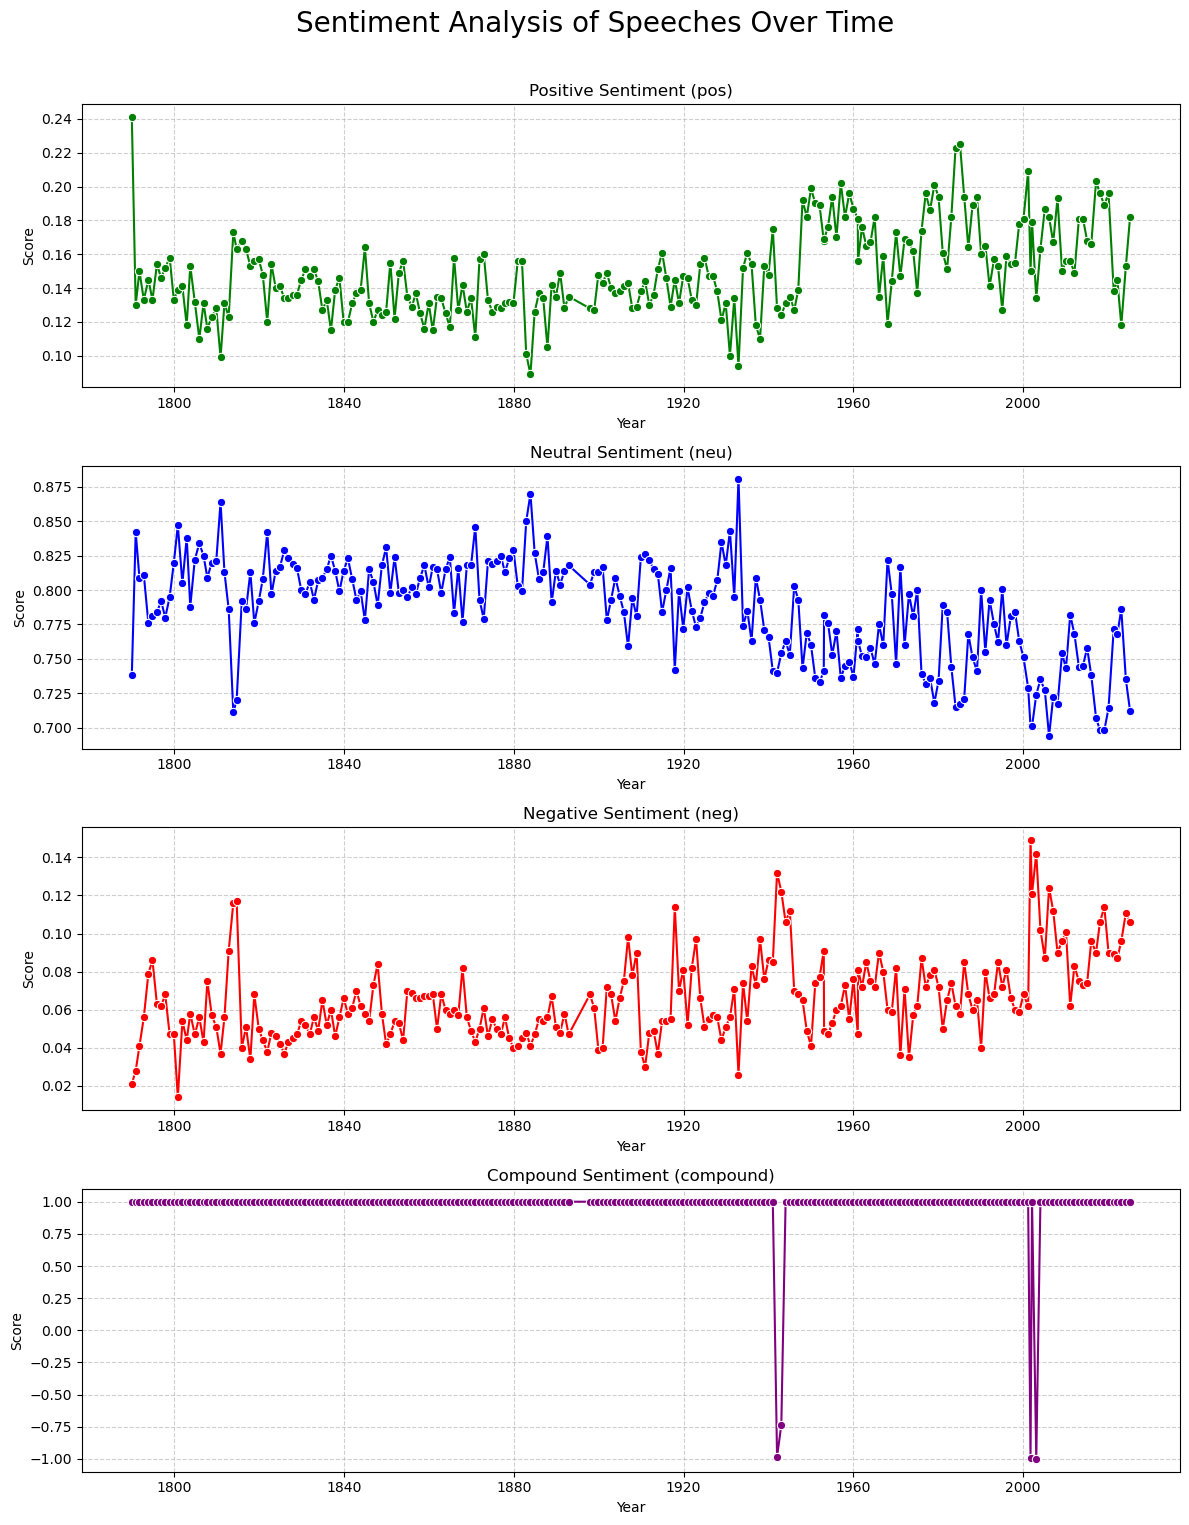

In [80]:
fig, axes = plt.subplots(4, 1, figsize=(12, 16))
fig.suptitle('Sentiment Analysis of Speeches Over Time', fontsize=20)

# Panel 1: Positive Sentiment
sns.lineplot(ax=axes[0], x='date', y='pos', data=speeches, marker='o', color='g')
axes[0].set_title('Positive Sentiment (pos)')
axes[0].set_ylabel('Score')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Panel 2: Neutral Sentiment
sns.lineplot(ax=axes[1], x='date', y='neu', data=speeches, marker='o', color='b')
axes[1].set_title('Neutral Sentiment (neu)')
axes[1].set_ylabel('Score')
axes[1].grid(True, linestyle='--', alpha=0.6)

# Panel 3: Negative Sentiment
sns.lineplot(ax=axes[2], x='date', y='neg', data=speeches, marker='o', color='r')
axes[2].set_title('Negative Sentiment (neg)')
axes[2].set_ylabel('Score')
axes[2].grid(True, linestyle='--', alpha=0.6)

# Panel 4: Compound Sentiment
sns.lineplot(ax=axes[3], x='date', y='compound', data=speeches, marker='o', color='purple')
axes[3].set_title('Compound Sentiment (compound)')
axes[3].set_ylabel('Score')
axes[3].set_xlabel('Year')
axes[3].grid(True, linestyle='--', alpha=0.6)

for ax in axes:
    # Set the x-axis label.
    ax.set_xlabel('Year')

# Adjust layout to prevent titles/labels from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

## Bag of words 💰

---

### Counting frequencies

- **Idea**: The most important terms in a document are the terms that occur most often.

- So, let's count the number of occurrences of each term in each document.<br><small>In other words, let's count the **frequency** of each term in each document.</small>

- For example, consider the following three documents:

<div align="center"><b>
big big big big data class<br>
data big data science<br>
science big data
    </b></div>

- Let's construct a matrix, where:
    - there is one row per **document**,
    - one column per unique **term**, and
    - the value in row $d$ and column $t$ is the **number of occurrences of term $t$ in document $d$**.

| | big | data | class |  science |
| --- | --- | --- | --- | --- |
| **big big big big data class** | 4 | 1 | 1 | 0 |
| **data big data science** | 1 | 2 | 0 | 1 |
| **science big data** | 1 | 1 | 0 | 1 |

### Bag of words

- The **bag of words** model represents documents as **vectors of word counts**, i.e. **term frequencies**.<br><small>The matrix below was created using the bag of words model.</small>

- Each **row** in the bag of words matrix is a **vector representation** of a document.

| | big | data | class |  science |
| --- | --- | --- | --- | --- |
| **big big big big data class** | 4 | 1 | 1 | 0 |
| **data big data science** | 1 | 2 | 0 | 1 |
| **science big data** | 1 | 1 | 0 | 1 |

- For example, we can represent the document 2, **data big data science**, with the vector $\vec{d_2}$:

$$\vec{d_2} = \begin{bmatrix} 1 \\ 2 \\ 0 \\ 1 \end{bmatrix}$$

<center><img src='imgs/bag-of-words.jpeg' width=1000></center>

<center><a href="https://42f6861cgkip12ijm63i3orf-wpengine.netdna-ssl.com/wp-content/uploads/2020/12/2020-07-bagofwords.jpg">(source)</a></center>

<br>

<center markdown="1">It is called "bag of words" because it doesn't consider <b>order</b>.</center>

### Aside: Interactive bag of words demo

Check [this](https://svelte.dev/repl/98d158ef6fb842d09c66ed20b9a31e99?version=3.55.1) site out – it automatically generates a bag of words matrix for you!

<center><img src='imgs/bow-interactive.png' width=50%>(<a href="https://twitter.com/jdwlbr/status/1622704535511916544?s=20">source</a>)</center>

### Applications of the bag of words model

- Now that we have a matrix of word counts, what can we do with it?

| | big | data | class |  science |
| --- | --- | --- | --- | --- |
| **big big big big data class** | 4 | 1 | 1 | 0 |
| **data big data science** | 1 | 2 | 0 | 1 |
| **science big data** | 1 | 1 | 0 | 1 |

- **Application**: We _could_ interpret the term with the largest value – that is, the **most frequent term** – in each document as being the most important.<br><small>This is imperfect. What if a document has the term "the" as its most frequent term?</small>

- **Application**: We could use the **vector** representations of documents to measure the **similarity** of two documents.<br><small>This would enable us to find, for example, the SOTU speeches that are most similar to one another!</small>

### The dot product

$$\require{color}$$

<div style="width: 100%;">
<div style="width: 65%; float: left"> 

- Recall, if $\color{purple} \vec{u} = \begin{bmatrix} u_1 \\ u_2 \\ ... \\ u_n \end{bmatrix}$ and $\color{#007aff} \vec{v} = \begin{bmatrix} v_1 \\ v_2 \\ ... \\ v_n \end{bmatrix}$ are two vectors, then their <b>dot product</b> ${\color{purple}\vec{u}} \cdot {\color{#007aff}\vec{v}}$ is defined as:

$${\color{purple}\vec{u}} \cdot {\color{#007aff}\vec{v}} = \sum_{i = 1}^n {\color{purple}u_i} {\color{#007aff} v_i} = {\color{purple}u_1} {\color{#007aff} v_1} + {\color{purple}u_2} {\color{#007aff} v_2} + ... + {\color{purple}u_n} {\color{#007aff} v_n}$$

- The dot product also has an equivalent **geometric** definition, which says that:

$${\color{purple}\vec{u}} \cdot {\color{#007aff}\vec{v}} = \lVert {\color{purple}\vec{u}} \rVert \lVert {\color{#007aff}\vec{v}} \rVert \cos \theta$$

<center><small>where $\theta$ is the angle between $\color{purple}\vec{u}$ and ${\color{#007aff}\vec{v}}$, and<br>$\lVert {\color{purple}\vec{u}} \rVert = \sqrt{{\color{purple} u_1}^2 + {\color{purple} u_2}^2 + ... + {\color{purple} u_n}^2}$<br>is the length of $\color{purple} \vec u$.</small></center>
    
- The two definitions are equivalent! This equivalence allows us to find the angle $\theta$ between two vectors.
        
</div>
    <div style="margin-left: 65%; height: 100px;" markdown="1"> 

<center>
<img src="imgs/theta-1-unlabeled.png" width=600>
</center>

</div>
</div>


### Angles and similarity

- <b>Key idea</b>: The more similar two vectors are, the <b>smaller</b> the angle $\theta$ between them is.

<div style="display: flex; justify-content: space-between;">
    <div style="flex: 1; text-align: center;">
        <img src="imgs/theta-2.png" width="415">
    </div>
    <div style="flex: 1; text-align: center;">
        <img src="imgs/theta-1.png" width="400">
    </div>
    <div style="flex: 1; text-align: center;">
        <img src="imgs/theta-3.png" width="415">
    </div>
</div>

- The smaller the angle $\theta$ between two vectors is, the **larger** $\cos \theta$ is.

- The maximum value of $\cos \theta$ is 1, achieved when $\theta = 0$.

- **Key idea: The more similar two vectors are, the larger $\cos \theta$ is!**

### Cosine similarity

- To measure the similarity between two documents, we can compute the **cosine similarity** of their vector representations:

$$\text{cosine similarity}(\vec u, \vec v) = \cos \theta = \boxed{\frac{\vec{u} \cdot \vec{v}}{|\vec{u}| | \vec{v}|}}$$

- If all elements in $\vec{u}$ and $\vec{v}$ are non-negative, then $\cos \theta$ ranges from 0 to 1.

- **Key idea: The more similar two vectors are, the larger $\cos \theta$ is!**

- Given a collection of documents, to find the most similiar **pair**, we can:
    1. Find the vector representation of each document.
    2. Find the cosine similarity of each pair of vectors.
    3. Return the documents whose vectors had the **largest** cosine similarity.

<div class="alert alert-success">
    <h3>Activity</h3>

Consider the matrix of word counts we found earlier, using the bag of words model:
                
| | big | data | class |  science |
| --- | --- | --- | --- | --- |
| **big big big big data class** | 4 | 1 | 1 | 0 |
| **data big data science** | 1 | 2 | 0 | 1 |
| **science big data** | 1 | 1 | 0 | 1 |

1. Which two documents have the highest **dot product**?
2. Which two documents have the highest **cosine similarity**?
    
</div>

### Normalizing

- Why can't we just use the dot product – that is, why must we divide by $|\vec{u}| | \vec{v}|$ when computing cosine similarity?

$$\text{cosine similarity}(\vec u, \vec v) = \cos \theta = \boxed{\frac{\vec{u} \cdot \vec{v}}{|\vec{u}| | \vec{v}|}}$$

| | big | data | class |  science |
| --- | --- | --- | --- | --- |
| **big big big big data class** | 4 | 1 | 1 | 0 |
| **data big data science** | 1 | 2 | 0 | 1 |
| **science big data** | 1 | 1 | 0 | 1 |

- Consider the following two _pairs_ of documents:

| Pair | Dot Product | Cosine Similarity |
| --- | --- | --- |
| **big big big big data class** and **data big data science** | 6 | 0.577 |
| **science big data** and **data big data science** | 4 | 0.943 |

- **"big big big big data class"** has a large dot product with **"data big data science"** just because the former has the term **"big"** four times. But intuitively, **"data big data science"** and **"science big data"** should be much more similar, since they have almost the exact same terms.

- **So, make sure to compute the cosine similarity – don't just use the dot product!**<br><small>If you don't normalize by the lengths of the vectors, documents with more terms will have artificially high similarities with other documents.</small>

### Issues with the bag of words model

- Recall, the bag of words model encodes a document as a vector containing **word frequencies**.

- It doesn't consider the **order** of the terms.
<br><small>**"big data science"** and **"data science big"** have the same vector representation, but mean different things.</small>

- It doesn't consider the **meaning** of terms.<br><small>**"I really really hate data"** and **"I really really love data"** have nearly identical vector representations, but very different meanings.</small>

- It treats all words as being equally important. <br><small>In **"I am a student"** and **"I am a teacher"**, it's clear to us humans that the most important terms are **"student"** and **"teacher"**, respectively. But in the bag of words model, **"student"** and **"I"** appear the same number of times in the first document.**This is the issue we'll address next lecture.**</small>